In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.linear_model import Ridge, Lasso

## Read in and Examine Data

In [27]:
train_df = pd.read_csv('data/train.csv', header = 0, index_col = ['Date'], infer_datetime_format = True)

In [28]:
train_df.index = pd.to_datetime(train_df.index)

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


In [30]:
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Extract the Weekly_Sales Column for EDA

In [31]:
weekly_sales = pd.DataFrame({'weekly_sales': train_df.Weekly_Sales})

In [32]:
weekly_sales.head()

,weekly_sales
Date,
2010-02-05,24924.50
2010-02-12,46039.49
2010-02-19,41595.55
2010-02-26,19403.54
2010-03-05,21827.90


## Group weekly_sales by date and take the average

In [94]:
weekly_sales_avg = weekly_sales.groupby(weekly_sales.index).mean()

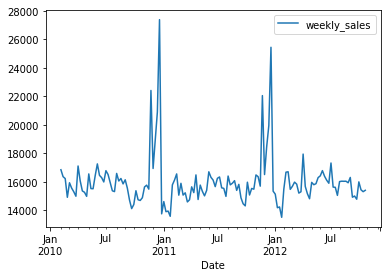

In [91]:
weekly_sales_avg.plot()
plt.show()

It seems like there's some seasonality. During December, sales incease. Try to remove seasonality and re-examine data.

## Seasonal Adjustment of Weekly Sales (52 weeks)

In [60]:
weekly_sales_avg_sa = weekly_sales_avg.diff(periods = 52)

In [61]:
weekly_sales_avg_sa.dropna(inplace = True)

In [62]:
weekly_sales_avg_sa.head()

,weekly_sales
Date,
2011-02-04,-1062.673220
2011-02-11,-240.349841
2011-02-18,325.332233
2011-02-25,150.197870
2011-03-04,-38.458682


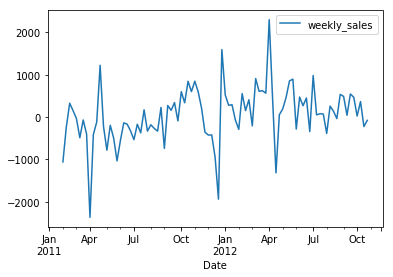

In [92]:
weekly_sales_avg_sa.plot()
plt.show()

There seems to be a slight drift in the data. Let's adjust for that.

## Adjust for Drift

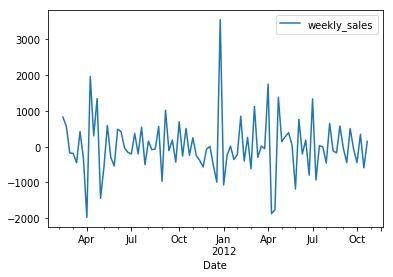

In [93]:
weekly_sales_avg_sa_diff = weekly_sales_avg_sa.diff().dropna()
weekly_sales_avg_sa_diff.plot()
plt.show()

It seems as though seasonality and drift is gone after two transformations.

## Fit AR(1), AR(2), MA(1), and ARMA(1, 1) Models and Examine AIC and BIC Values

In [108]:
# initialize dfs to store results
aic_df = pd.DataFrame(columns = ['model', 'aic'])
bic_df = pd.DataFrame(columns = ['model', 'bic'])

In [113]:
# Fit the data to an AR(1) model and print AIC:
mod = ARMA(weekly_sales_avg_sa_diff, order=(1,0))
res = mod.fit()

aic_df.loc[0] = ['AR(1)', res.aic]
bic_df.loc[0] = ['AR(1)', res.bic]

# Fit the data to an AR(2) model and print AIC:
mod = ARMA(weekly_sales_avg_sa_diff, order=(2,0))
res = mod.fit()

aic_df.loc[1] = ['AR(2)', res.aic]
bic_df.loc[1] = ['AR(2)', res.bic]

# Fit the data to an MA(1) model and print AIC:
mod = ARMA(weekly_sales_avg_sa_diff, order=(0,1))
res = mod.fit()

aic_df.loc[2] = ['MA(1)', res.aic]
bic_df.loc[2] = ['MA(1)', res.bic]

# Fit the data to an ARMA(1,1) model and print AIC:
mod = ARMA(weekly_sales_avg_sa_diff, order=(1,1))
res = mod.fit()

aic_df.loc[3] = ['ARMA(1,1)', res.aic]
bic_df.loc[3] = ['ARMA(1,1)', res.bic]

aic_df = aic_df.sort_values(by = 'aic')
bic_df = bic_df.sort_values(by = 'bic')

/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/root/anaconda3/lib/python3.6/site-packages/scipy/sign

In [114]:
aic_df

,model,aic
3,"ARMA(1,1)",1421.115069
2,MA(1),1421.818895
1,AR(2),1442.902570
0,AR(1),1448.601448


In [115]:
bic_df

,model,bic
2,MA(1),1429.318324
3,"ARMA(1,1)",1431.114308
1,AR(2),1452.901808
0,AR(1),1456.100877


It seems like MA(1) and ARMA(1,1) have the lowest AIC and BIC values.

## Other EDA

In [35]:
# calculate pct change from week to week
weekly_avg_pct_chg = weekly_sales_avg.pct_change()

In [36]:
weekly_avg_pct_chg.head()

,weekly_sales
Date,
2010-02-05,NaN
2010-02-12,-0.028752
2010-02-19,-0.008280
2010-02-26,-0.081220
2010-03-05,0.068557


In [37]:
autocorrelation = weekly_avg_pct_chg.weekly_sales.autocorr()

In [38]:
autocorrelation # negative means mean-reverting

-0.4219040441969675

# Plot of autocorrelation

In [39]:
acf_array = acf(weekly_avg_pct_chg[1:])

acf_array

array([ 1.00000000e+00, -4.21740411e-01,  7.32150133e-02, -1.84721699e-01,
        3.84375046e-01, -3.82300218e-01,  7.14658033e-03,  6.63186040e-02,
        4.79213731e-02, -4.70912024e-02, -1.78081285e-02,  8.19539245e-02,
       -6.69858975e-02, -1.77617303e-03, -8.61209340e-02,  8.28294737e-02,
       -1.00232239e-02,  3.92336615e-02, -6.53245402e-02,  6.16295773e-02,
       -2.54074533e-02, -2.30337150e-02, -4.67504352e-02,  6.30201181e-03,
        2.25198652e-02,  1.07378041e-02,  4.12164534e-02, -2.29572279e-02,
        3.28285635e-02,  6.33520998e-02, -7.57313252e-02, -4.23418046e-02,
        8.38728033e-04,  2.21453934e-02, -3.95002114e-02,  4.72741165e-02,
       -2.86429166e-02,  5.56072477e-02, -4.01342020e-03, -6.30962581e-02,
       -6.66088528e-02])

In [40]:
len(acf_array)

41

In [41]:
nobs = len(weekly_avg_pct_chg[1:])

In [42]:
conf = 1.96/sqrt(nobs)

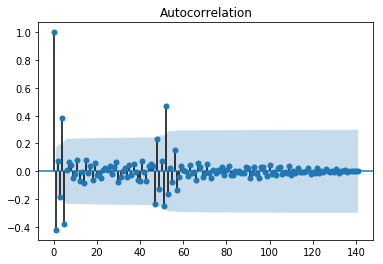

In [43]:
plot_acf(weekly_avg_pct_chg[1:], alpha = 0.05)
plt.show()

We see up to lag 5 values and then annual data are highly correlated. Sign of autocorrelation function is reversing at each lag. This means phi is a negative value (mean reversion)

## Are the weekly sales a random walk?

In [44]:
weekly_sales_avg_diff = weekly_sales_avg.diff()

In [45]:
weekly_sales_avg_diff_cum_sum = np.cumsum(weekly_sales_avg_diff)

In [46]:
weekly_sales_avg_diff_cum_sum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-02-05 to 2012-10-26
Data columns (total 1 columns):
weekly_sales    142 non-null float64
dtypes: float64(1)
memory usage: 2.2 KB


In [47]:
weekly_sales_avg_diff_cum_sum.head()

,weekly_sales
Date,
2010-02-05,NaN
2010-02-12,-484.065965
2010-02-19,-619.463018
2010-02-26,-1936.572308
2010-03-05,-915.106270


In [48]:
len(weekly_sales_avg_diff_cum_sum.index)

143

In [49]:
weekly_sales_avg_diff_cum_sum.sort_values('weekly_sales', ascending = False).head()

,weekly_sales
Date,
2010-12-24,10542.570696
2011-12-23,8601.024125
2010-11-26,5567.214709
2011-11-25,5207.441479
2010-12-17,4056.341623


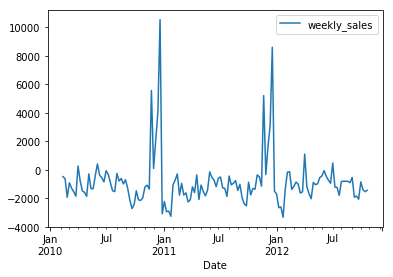

In [50]:
ax = weekly_sales_avg_diff_cum_sum.plot()
plt.show()

Based on the plot, it doesn't seem like weekly_sales is a random walk. Let's confirm by doing the Augmented Dickey-Fuller Test

### Augmented Dickey-Fuller Test for Weekly Sales

In [51]:
weekly_sales_avg.head()

,weekly_sales
Date,
2010-02-05,16836.121997
2010-02-12,16352.056032
2010-02-19,16216.658979
2010-02-26,14899.549688
2010-03-05,15921.015727


In [52]:
adft_results = adfuller(weekly_sales_avg.weekly_sales)

In [53]:
print(adft_results)

(-5.93080274474869, 2.383227270610516e-07, 4, 138, {'1%': -3.47864788917503, '5%': -2.882721765644168, '10%': -2.578065326612056}, 2261.7748547116485)


In [54]:
print('The p-value of the test on weekly sales is: ' + str(adft_results[1]))

The p-value of the test on weekly sales is: 2.383227270610516e-07


This does not seem like a random walk. There seems to be a certain pattern. During December, the change is very positive. Further, the Augmented Dickey-Fuller test confirms this with a very small p-value.

### Augmented Dickey-Fuller Test for Weekly Sales Percent Change

In [55]:
weekly_avg_pct_chg.head()

,weekly_sales
Date,
2010-02-05,NaN
2010-02-12,-0.028752
2010-02-19,-0.008280
2010-02-26,-0.081220
2010-03-05,0.068557


In [56]:
weekly_avg_pct_chg = weekly_avg_pct_chg.dropna()

In [57]:
adft_pct_chg_results = adfuller(weekly_avg_pct_chg['weekly_sales'])

In [58]:
print('The p-value of the test on percent change is: ' + str(adft_pct_chg_results[1]))

The p-value of the test on percent change is: 2.561129648931944e-10


We reject the null hypothesis that the percent change follow a random walk.

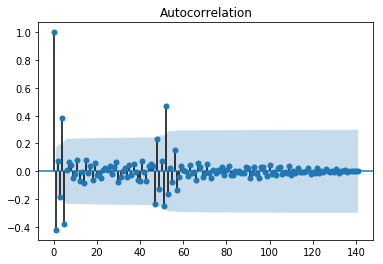

In [59]:
plot_acf(weekly_avg_pct_chg)
plt.show()

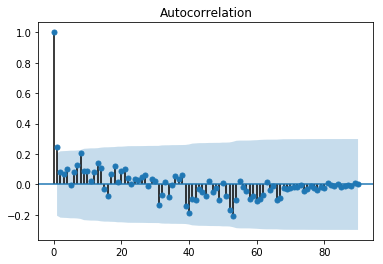

In [63]:
plot_acf(weekly_sales_avg_sa)
plt.show()

In [66]:
adft_weekly_sales_avg_sa_results = adfuller(weekly_sales_avg_sa.weekly_sales)

In [67]:
adft_weekly_sales_avg_sa_results

(-7.398812742689997,
 7.6511299143739e-11,
 0,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 1220.1211308259037)

Seasonality looks like it's removed. This is also not a random walk.

## PACF

/root/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


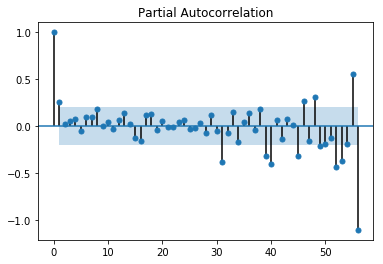

In [68]:
plot_pacf(weekly_sales_avg_sa, lags = 56)
plt.show()

## AR(1) Model

In [69]:
ar1 = ARMA(weekly_sales_avg_sa, order = (1, 0))

/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [70]:
ar1_fit = ar1.fit()

/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an a

In [71]:
ar1_fit.params

const                 42.053788
ar.L1.weekly_sales     0.254829
dtype: float64

In [72]:
ar1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           weekly_sales   No. Observations:                   91
Model:                     ARMA(1, 0)   Log Likelihood                -715.529
Method:                       css-mle   S.D. of innovations            628.695
Date:                Wed, 14 Nov 2018   AIC                           1437.058
Time:                        11:19:16   BIC                           1444.590
Sample:                    02-04-2011   HQIC                          1440.097
                         - 10-26-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 42.0538     88.147      0.477      0.634    -130.711     214.819
ar.L1.weekly_sales     0.2548      0.102      2.487      0.015       0.054       0.456
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.9242           +0.0000j            3.9242            0.0000
-----------------------------------------------------------------------------
"""

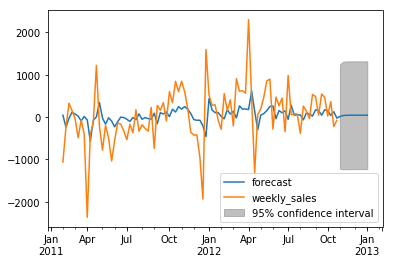

In [73]:
ar1_fit.plot_predict(start = 0, end = '2013')
plt.show()

In [74]:
ar1_fit.bic

1444.5902871045828

/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/root/anaconda3/lib/python3.6/site-packages/scipy/sign

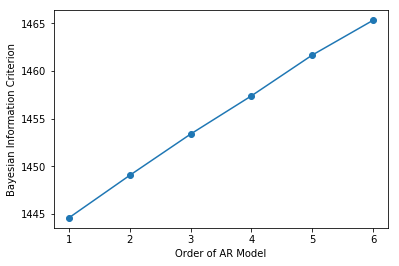

In [75]:
# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARMA(weekly_sales_avg_sa, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/root/anaconda3/lib/python3.6/site-packages/scipy/sign

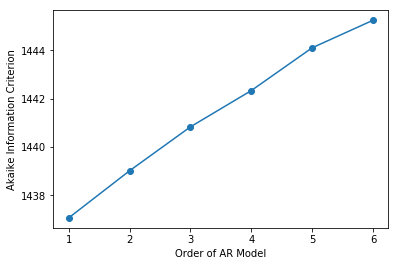

In [76]:
# Fit the data to an AR(p) for p = 0,...,6 , and save the AIC
AIC = np.zeros(7)
for p in range(7):
    mod = ARMA(weekly_sales_avg_sa, order=(p,0))
    res = mod.fit()
# Save AIC for AR(p)    
    AIC[p] = res.aic
    
# Plot the AIC as a function of p
plt.plot(range(1,7), AIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Akaike Information Criterion')
plt.show()

## MA(1) Model

In [78]:
ma1 = ARMA(weekly_sales_avg_sa, order=(0, 1))
ma1_fit = ma1.fit()

/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [79]:
ma1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           weekly_sales   No. Observations:                   91
Model:                     ARMA(0, 1)   Log Likelihood                -715.790
Method:                       css-mle   S.D. of innovations            630.543
Date:                Wed, 14 Nov 2018   AIC                           1437.581
Time:                        11:20:29   BIC                           1445.113
Sample:                    02-04-2011   HQIC                          1440.620
                         - 10-26-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 43.8626     81.387      0.539      0.591    -115.654     203.379
ma.L1.weekly_sales     0.2338      0.095      2.448      0.016       0.047       0.421
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -4.2775           +0.0000j            4.2775            0.5000
-----------------------------------------------------------------------------
"""

In [80]:
ma1_fit.params

const                 43.862569
ma.L1.weekly_sales     0.233781
dtype: float64

/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


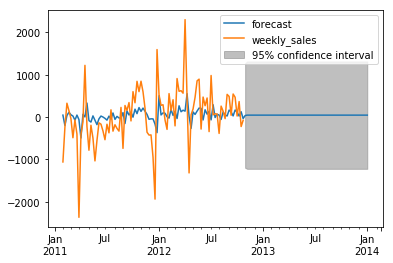

In [81]:
ma1_fit.plot_predict(end = '2014')
plt.show()

In [82]:
weekly_avg_pct_chg_sa = weekly_sales_avg_sa.pct_change().dropna()

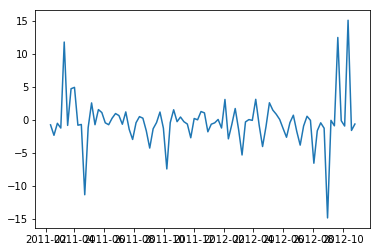

In [83]:
plt.plot(weekly_avg_pct_chg_sa)
plt.show()

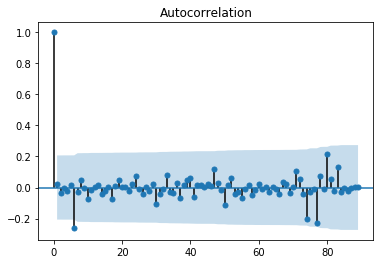

In [84]:
plot_acf(weekly_avg_pct_chg_sa)
plt.show()

In [85]:
ma1_sa = ARMA(weekly_avg_pct_chg_sa, order = (0, 1))

/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [86]:
ma1_sa_fit = ma1_sa.fit()

In [87]:
print(ma1_sa_fit.params)

const                -0.357843
ma.L1.weekly_sales    0.023400
dtype: float64


In [88]:
ar1_sa = ARMA(weekly_avg_pct_chg_sa, order = (1, 0))

/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [89]:
ar1_sa_fit = ar1_sa.fit()

/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an a

In [90]:
ar1_sa_fit.params

const                -0.357856
ar.L1.weekly_sales    0.021712
dtype: float64

/root/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/root/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


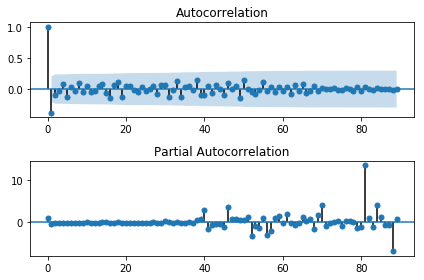

In [115]:
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(weekly_sales_avg_sa_diff, ax=axes[0])

# Plot the PACF
plot_pacf(weekly_sales_avg_sa_diff, ax=axes[1])
fig.tight_layout()
fig.show()

No clear pattern except in the partial autocorrelation. That looks weird.

In [117]:
# Fit the data to an AR(1) model and print AIC:
mod = ARMA(weekly_sales_avg_sa, order=(1,0))
res = mod.fit()
print("The AIC for an AR(1) is: ", res.aic)

# Fit the data to an AR(2) model and print AIC:
mod = ARMA(weekly_sales_avg_sa, order=(2,0))
res = mod.fit()
print("The AIC for an AR(2) is: ", res.aic)

# Fit the data to an MA(1) model and print AIC:
mod = ARMA(weekly_sales_avg_sa, order=(0,1))
res = mod.fit()
print("The AIC for an MA(1) is: ", res.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod = ARMA(weekly_sales_avg_sa, order=(1,1))
res = mod.fit()
print("The AIC for an ARMA(1,1) is: ", res.aic)

/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/root/anaconda3/lib/python3.6/site-packages/scipy/sign

The AIC for an AR(1) is:  1437.0577085850323
The AIC for an AR(2) is:  1439.0103208759165
The AIC for an MA(1) is:  1437.5806849811866
The AIC for an ARMA(1,1) is:  1438.9769930799944


/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [125]:
# Fit the data to an AR(1) model and print BIC:
mod = ARMA(weekly_sales_avg_sa, order=(1,0))
res = mod.fit()
print("The BIC for an AR(1) is: ", res.bic)

# Fit the data to an AR(2) model and print BIC:
mod = ARMA(weekly_sales_avg_sa, order=(2,0))
res = mod.fit()
print("The BIC for an AR(2) is: ", res.bic)

# Fit the data to an MA(1) model and print BIC:
mod = ARMA(weekly_sales_avg_sa, order=(0,1))
res = mod.fit()
print("The BIC for an MA(1) is: ", res.bic)

# Fit the data to an ARMA(1,1) model and print BIC:
mod = ARMA(weekly_sales_avg_sa, order=(1,1))
res = mod.fit()
print("The BIC for an ARMA(1,1) is: ", res.bic)

/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/root/anaconda3/lib/python3.6/site-packages/scipy/sign

The BIC for an AR(1) is:  1444.5902871045828
The BIC for an AR(2) is:  1449.0537589019839
The BIC for an MA(1) is:  1445.113263500737
The BIC for an ARMA(1,1) is:  1449.0204311060618


/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


## ARIMA Model

In [138]:
arima = ARIMA(weekly_sales_avg_sa_diff, order = (0, 0, 1))

/root/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


In [133]:
arima_fit = arima.fit()

/root/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


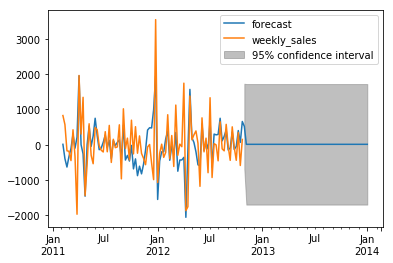

In [136]:
arima_fit.plot_predict(end = '2014')
plt.show()

## Extract week of year from date

In [140]:
weekly_sales_avg.head()

,weekly_sales
Date,
2010-02-05,16836.121997
2010-02-12,16352.056032
2010-02-19,16216.658979
2010-02-26,14899.549688
2010-03-05,15921.015727


In [141]:
weekly_sales_avg['week_of_year'] = weekly_sales_avg.index.week

## Shifted Auto-Regressive Modeling

In [146]:
weekly_sales_avg_sa.head()

,weekly_sales
Date,
2011-02-04,-1062.673220
2011-02-11,-240.349841
2011-02-18,325.332233
2011-02-25,150.197870
2011-03-04,-38.458682


In [148]:
weekly_sales_avg_sa_series = weekly_sales_avg_sa.weekly_sales

In [149]:
# These are the "time lags"
shifts = np.arange(1, 52).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_week".format(week_shift): weekly_sales_avg_sa_series.shift(week_shift) for week_shift in shifts}

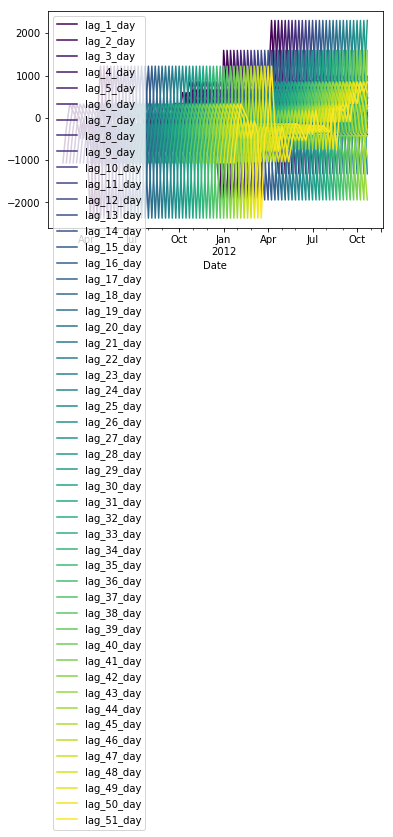

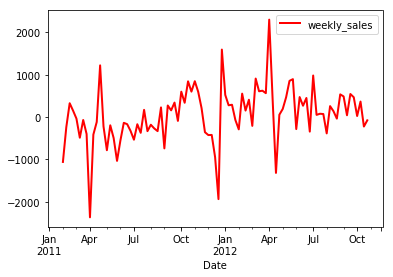

In [150]:
# Convert into a DataFrame for subsequent use
weekly_sales_avg_sa_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = weekly_sales_avg_sa_shifted.plot(cmap=plt.cm.viridis)
weekly_sales_avg_sa.plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

In [154]:
X = weekly_sales_avg_sa_shifted.fillna(np.nanmedian(weekly_sales_avg_sa_shifted))
y = weekly_sales_avg_sa_series

In [155]:
model = Ridge()
model.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [158]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
    return ax

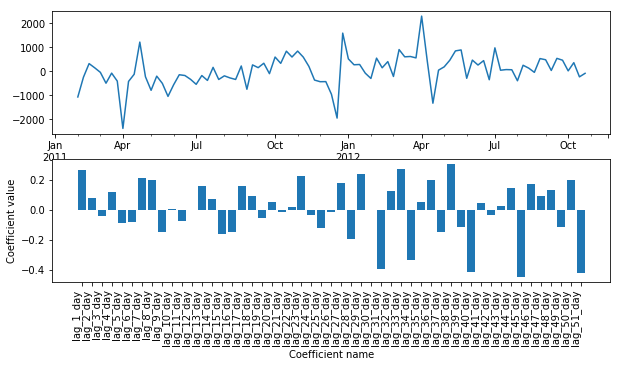

In [159]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, weekly_sales_avg_sa_shifted.columns, ax=axs[1])
plt.show()

## Transform Data to Rolling Data (20) and Analyze

In [160]:
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


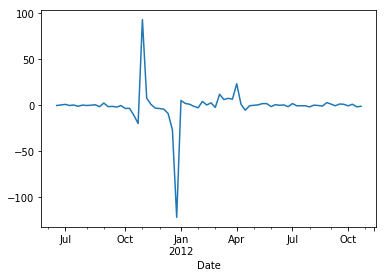

In [162]:
# Apply your custom function and plot
weekly_sales_rolling_avg = weekly_sales_avg_sa_series.rolling(20).apply(percent_change)
weekly_sales_rolling_avg.plot()
plt.show()

In [163]:
# These are the "time lags"
shifts = np.arange(1, 52).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_week".format(week_shift): weekly_sales_rolling_avg.shift(week_shift) for week_shift in shifts}

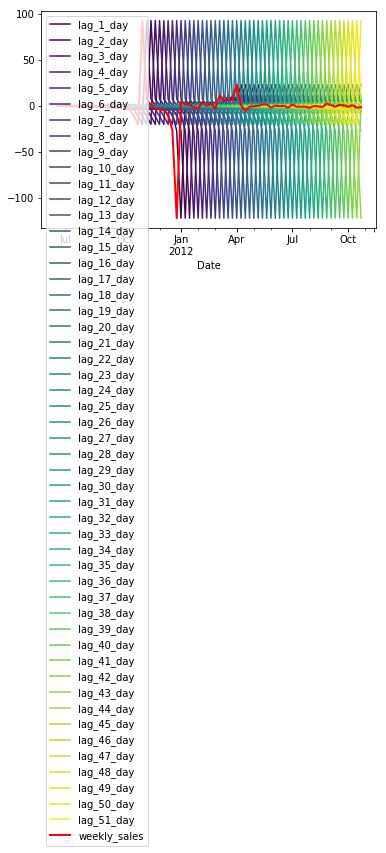

In [166]:
# Convert into a DataFrame for subsequent use
weekly_sales_rolling_avg_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = weekly_sales_rolling_avg_shifted.plot(cmap=plt.cm.viridis)
weekly_sales_rolling_avg.plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

## Ridge Regression

In [171]:
X = weekly_sales_rolling_avg_shifted.fillna(np.nanmedian(weekly_sales_rolling_avg_shifted))
y = weekly_sales_rolling_avg.fillna(np.nanmedian(weekly_sales_rolling_avg))

In [172]:
model = Ridge()
model.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

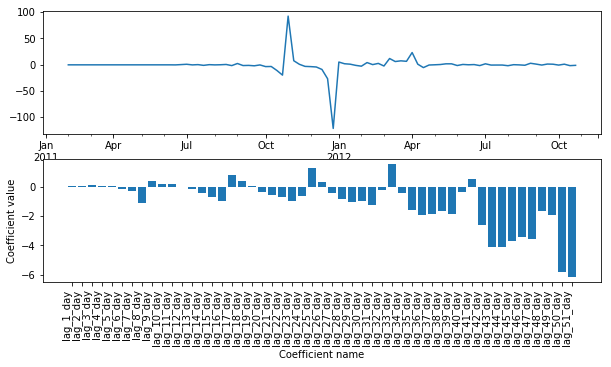

In [173]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, weekly_sales_rolling_avg_shifted.columns, ax=axs[1])
plt.show()

## LASSO Regression

In [176]:
model = Lasso()
model.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

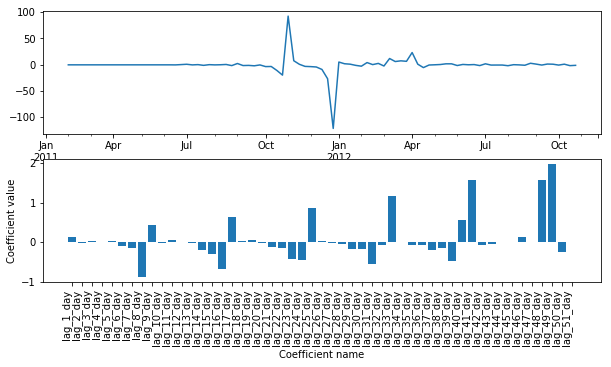

In [177]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, weekly_sales_rolling_avg_shifted.columns, ax=axs[1])
plt.show()

## Rolling 52 days analyze

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


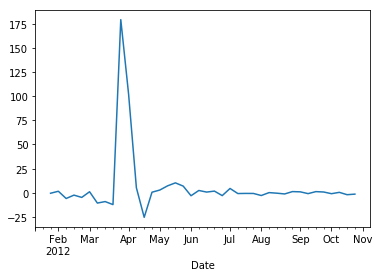

In [178]:
# Apply your custom function and plot
weekly_sales_rolling_avg = weekly_sales_avg_sa_series.rolling(52).apply(percent_change)
weekly_sales_rolling_avg.plot()
plt.show()

In [179]:
# These are the "time lags"
shifts = np.arange(1, 52).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_week".format(week_shift): weekly_sales_rolling_avg.shift(week_shift) for week_shift in shifts}

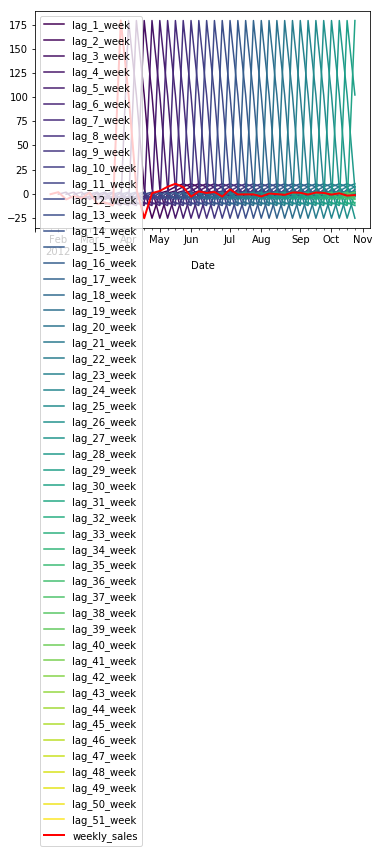

In [180]:
# Convert into a DataFrame for subsequent use
weekly_sales_rolling_avg_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = weekly_sales_rolling_avg_shifted.plot(cmap=plt.cm.viridis)
weekly_sales_rolling_avg.plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

## Ridge Regression

In [181]:
X = weekly_sales_rolling_avg_shifted.fillna(np.nanmedian(weekly_sales_rolling_avg_shifted))
y = weekly_sales_rolling_avg.fillna(np.nanmedian(weekly_sales_rolling_avg))

In [182]:
model = Ridge()
model.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

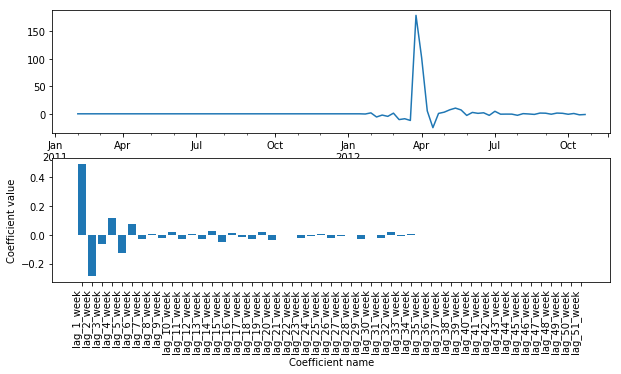

In [183]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, weekly_sales_rolling_avg_shifted.columns, ax=axs[1])
plt.show()

## LASSO Regression

In [184]:
model = Lasso()
model.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

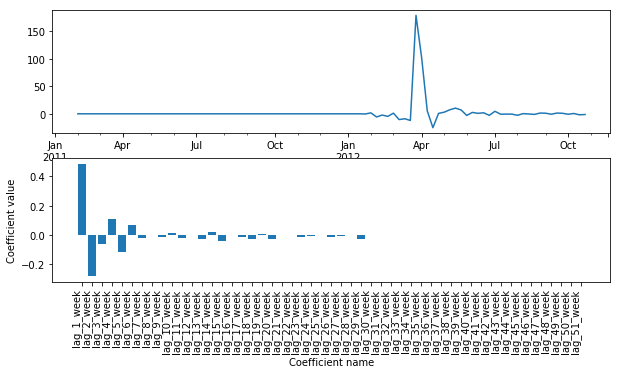

In [185]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, weekly_sales_rolling_avg_shifted.columns, ax=axs[1])
plt.show()